In [1]:
%matplotlib inline


# Multiway Cluster Robust DML

This example shows how the multiway cluster roboust DML (Chiang et al. 2020) can be implemented with the DoubleML
package.
Chiang et al. (2020) consider double-indexed data

\begin{equation}
\lbrace W_{ij}: i \in \lbrace 1, \ldots, N \rbrace, j \in \lbrace 1, \ldots, M \rbrace \rbrace
\end{equation}

and the partially linear IV regression model (PLIV)

$$\begin{aligned}
Y_{ij} = D_{ij} \theta_0 +  g_0(X_{ij}) + \epsilon_{ij}, & &\mathbb{E}(\epsilon_{ij} | X_{ij}, Z_{ij}) = 0, \\
Z_{ij} = m_0(X_{ij}) + v_{ij}, & &\mathbb{E}(v_{ij} | X_{ij}) = 0.
\end{aligned}$$

TODO: Add a few more details and the reference!
https://arxiv.org/pdf/1909.03489.pdf


In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns

from sklearn.model_selection import KFold, RepeatedKFold
from sklearn.base import clone

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

from doubleml import DoubleMLData, DoubleMLPLIV
from doubleml.double_ml_resampling import DoubleMLMultiwayResampling

from doubleml.datasets import make_pliv_multiway_cluster_CKMS2019

## Simulate multiway cluster data

We use the PLIV data generating process described in Section 4.1 of Chiang et al. (2020).



In [3]:
# Set the simulation parameters
N = 25  # number of observations (first dimension)
M = 25  # number of observations (second dimension)
dim_X = 100  # dimension of X

obj_dml_data = make_pliv_multiway_cluster_CKMS2019(N, M, dim_X)

In [4]:
# The data comes with multi index for rows (tuples with two entries)
obj_dml_data.data.head(30)

X1        X2        X3        X4        X5        X6        X7  \
0 0  -0.003796  1.506757  0.138997 -0.326714  0.134775  0.275427  0.106505   
  1  -0.694617  0.990294  0.343606 -1.076013  0.293443  1.082898  1.436888   
  2   0.486762  0.382255 -0.454169 -1.346418 -1.181131 -0.190395  1.028512   
  3   0.914272  1.560884  0.282921 -0.988501  0.757588 -0.459112  1.216922   
  4  -0.545963  0.889222 -0.318390 -0.670043  0.098506 -0.885228 -0.209280   
  5  -0.212142 -0.405451 -1.122426 -0.439877 -0.625086 -0.339065 -0.500090   
  6   0.426124  0.713926  0.718850  0.277348  0.019491 -0.385506  0.262410   
  7  -0.059893  1.268181 -0.152960  0.109039  0.276123 -0.204681 -0.471425   
  8   0.235491 -0.333538  0.894954  0.069128 -0.203384  0.107307  0.257537   
  9  -0.167174 -0.241565 -0.185725 -0.854056  0.112079 -0.460442  0.409435   
  10 -0.149732  1.381695 -0.177289  0.274146  0.483436 -0.361360  0.458230   
  11 -0.137111 -0.289635  0.302722  0.021230 -0.379886 -0.064158  0.191884   
  12 -0.084895  0.496653  0.007104 -0.379302 -0.337530  0.766930  0.795891   
  13  0.042177  1.024224  0.033722 -0.285457  0.643268  0.009551  0.323631   
  14  0.052352 -0.035408  0.670067  0.211390  0.546106  0.110855 -0.166341   
  15  0.332187  0.199510  0.428559 -0.595786  0.252814 -0.113641  0.382481   
  16  0.812499  1.042489  1.026129  0.152697 -0.573081  0.080860 -0.428851   
  17 -1.171349  0.086329  0.453687  0.378210 -1.030898 -0.189440  0.968196   
  18 -0.603031 -0.774579  0.564799  0.241835 -0.072931  0.664896  1.038424   
  19  0.880812 -0.730428  0.493521  0.027251 -0.106871 -0.364292  0.343945   
  20 -0.431686 -0.356512  0.669707  0.304765  0.249568 -0.070415  0.775392   
  21 -0.741413 -0.506923 -0.028562  0.179629  0.320471  0.083490  0.789812   
  22 -0.543173 -0.279137 -1.180034 -0.530141  0.390952  1.002440 -0.217828   
  23  0.221901  0.514804 -0.189523  0.162466 -0.867725 -0.156732  0.736339   
  24  0.701580  1.457416 -0.617707 -0.809017 -0.332072 -0.593163  1.101097   
1 0  -0.172903 -0.089148  0.031882 -0.435801 -0.414301  0.234297  0.173932   
  1   0.005823  0.083356  1.084246  0.068353  0.537914 -0.374278  0.542535   
  2  -0.336624  0.609038  0.538189  0.226640  0.216699 -1.023264 -1.045442   
  3  -0.225110 -0.060048 -0.471541  0.588398  0.044076 -0.730371  0.329249   
  4  -0.475754  0.074299  0.210642  0.646827  0.034671 -0.024927 -0.610108   

            X8        X9       X10  ...       X94       X95       X96  \
0 0   0.330622  0.567719 -0.491855  ... -0.538242 -0.218876  0.417199   
  1  -0.049601  0.178543  1.352090  ... -0.248019 -0.000597  0.988856   
  2  -0.299501 -1.317752  0.432751  ...  0.283770 -0.283840  0.684684   
  3   0.603235 -0.119547  0.482858  ... -0.717071 -0.308183  0.193012   
  4  -0.842649 -0.708046  0.848092  ... -0.090435  0.475783  0.079903   
  5   0.184499 -0.389515  0.153544  ... -0.910970  0.195405  0.088985   
  6  -0.052917 -0.130682  0.202277  ... -0.646712  1.110424  0.719505   
  7   0.967941  0.279812  1.125023  ...  0.155693 -0.076207 -0.106127   
  8   0.035835 -0.431612 -0.254874  ... -0.080188 -0.051403 -0.485398   
  9  -0.081476 -0.186580 -0.337468  ... -0.562199 -0.300360 -0.586221   
  10  0.537109 -0.271352  1.032383  ... -1.039553 -0.087978  0.423410   
  11  1.337275  0.018319  0.569010  ... -1.076404 -0.720237 -0.109154   
  12  0.277791  0.702710  0.143798  ... -0.753626  0.064759  0.573414   
  13  0.352003  0.058792  0.151235  ... -0.072689  0.084658 -0.069450   
  14  0.803269  0.031608  0.730109  ... -0.211711  0.053583  0.712562   
  15  0.582784 -0.793399 -0.635632  ...  0.131168 -1.142090  0.032641   
  16  0.187156 -0.260123 -0.746268  ... -0.872882 -0.869771 -0.303681   
  17 -0.476068 -0.339810  0.977000  ...  0.258584  0.289274 -0.563891   
  18  0.470515  0.281177  0.562660  ... -0.489356  0.285040  0.379920   
  19  0.508362  0.019714  0.033528  ... -0.738467  0.455631  0.580056   
  20  0.559345 -0.401639  0.150162  ... -0.463216 -0.016480 

## Initialize the objects of class DoubleMLData and DoubleMLPLIV



In [5]:
# Set machine learning methods for m & g
learner = RandomForestRegressor(max_depth=2, n_estimators=10)
ml_g = clone(learner)
ml_m = clone(learner)
ml_r = clone(learner)

# initialize the DoubleMLPLIV object
dml_pliv_obj = DoubleMLPLIV(obj_dml_data,
                            ml_g,
                            ml_m,
                            ml_r,
                            score='partialling out',
                            dml_procedure='dml1',
                            draw_sample_splitting=False)

## Split samples and transfer the sample splitting to the object



In [6]:
K = 3  # number of folds
smpl_sizes = [N, M]
obj_dml_multiway_resampling = DoubleMLMultiwayResampling(K, smpl_sizes)
smpls_multi_ind, smpls_lin_ind = obj_dml_multiway_resampling.split_samples()

dml_pliv_obj.set_sample_splitting([smpls_lin_ind])

## Fit the model and show a summary



In [7]:
dml_pliv_obj.fit()
print(dml_pliv_obj.summary)

       coef   std err          t          P>|t|   2.5 %    97.5 %
D  0.976266  0.035442  27.545128  5.061913e-167  0.9068  1.045731


## Visualization of sample splitting with tuple and linear indexing



In [8]:
#discrete color scheme
x = sns.color_palette("RdBu_r", 7)
cMap = ListedColormap([x[0], x[3], x[6]])
plt.rcParams['figure.figsize'] = 15, 12
sns.set(font_scale=1.3)

### Visualize sample splitting with tuples (one plot per fold)



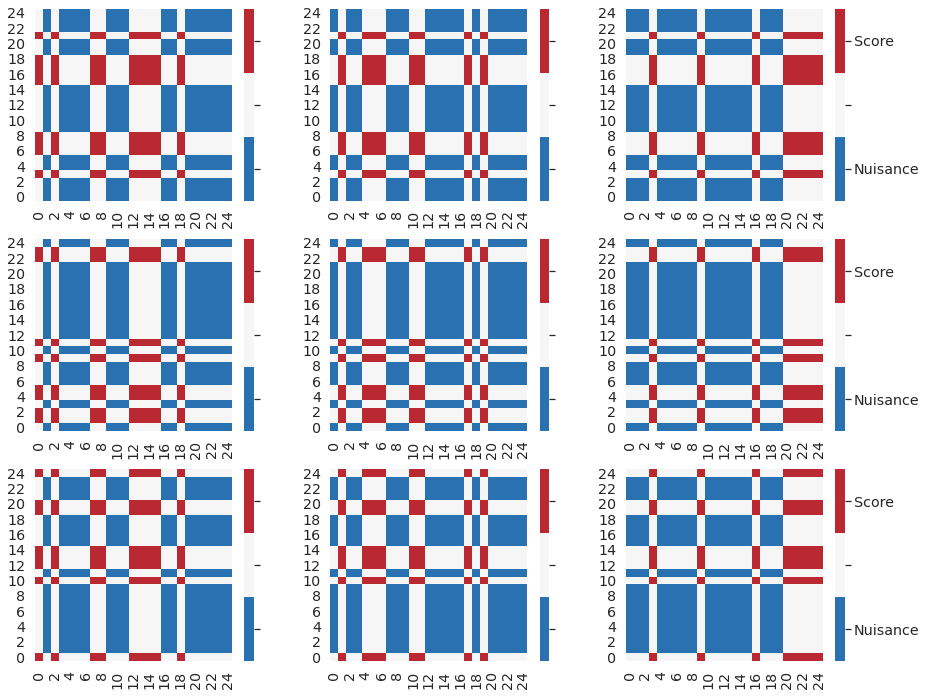

In [9]:
for i_split, this_split_ind in enumerate(smpls_multi_ind):
    plt.subplot(K, K, i_split + 1)
    df = pd.DataFrame(np.zeros([N, M]))
    ind_array_train = np.array([*this_split_ind[0]])
    ind_array_test = np.array([*this_split_ind[1]])
    df.loc[ind_array_train[:, 0], ind_array_train[:, 1]] = -1.
    df.loc[ind_array_test[:, 0], ind_array_test[:, 1]] = 1.

    ax = sns.heatmap(df, cmap=cMap);
    ax.invert_yaxis();
    ax.set_ylim([0, M]);
    colorbar = ax.collections[0].colorbar
    colorbar.set_ticks([-0.667, 0, 0.667])
    if i_split % K == (K - 1):
        colorbar.set_ticklabels(['Nuisance', '', 'Score'])
    else:
        colorbar.set_ticklabels(['', '', ''])

### Visualize sample splitting with linear indexing (one column per fold)



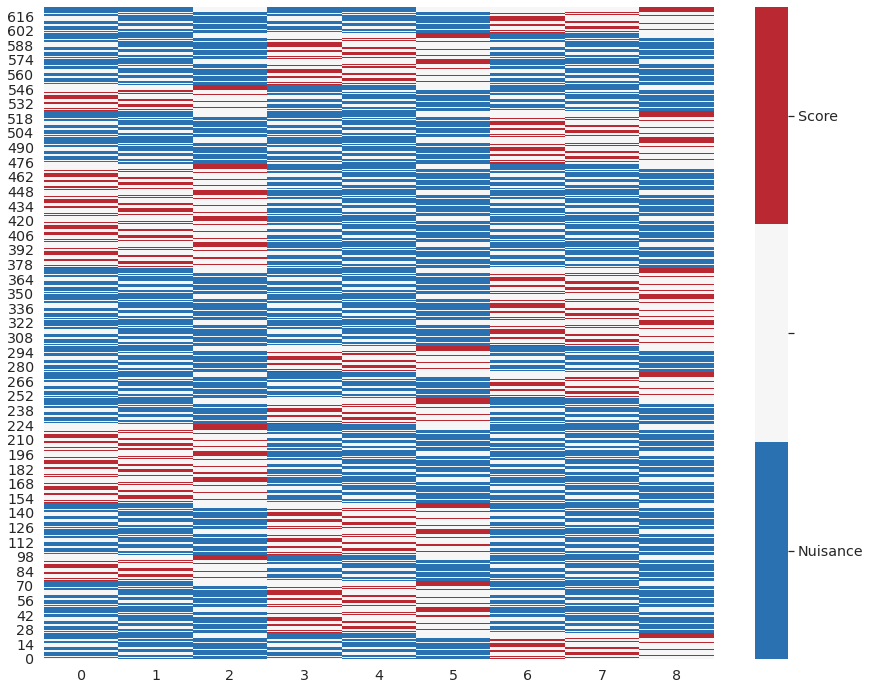

In [10]:
df = pd.DataFrame(np.zeros([N*M, K*K]))
for i_split, this_split_ind in enumerate(smpls_lin_ind):
    df.loc[this_split_ind[0], i_split] = -1.
    df.loc[this_split_ind[1], i_split] = 1.

ax = sns.heatmap(df, cmap=cMap);
ax.invert_yaxis();
ax.set_ylim([0, N*M]);
colorbar = ax.collections[0].colorbar
colorbar.set_ticks([-0.667, 0, 0.667])
colorbar.set_ticklabels(['Nuisance', '', 'Score'])